# Beta Forecasting

This is a study of forecasting an asset's beta ($\beta$), defined by a linear model relating an asset’s return $r_i$ to the market’s return $r_m$
$$
r_i = \alpha + \beta r_m + \text{noise}~,
$$
here we use simple returns, and $i$ labels the asset while $m$ labels the market (we use SPY as the market proxy). Our goal is to forecast the $\beta$ you would get on any given trading day $T$ if you were able to fit the simple model above using the next 45 trading days, that is, if you could peek at the next 45 days. If you actually did have access to the returns from those future days, your estimate would turn out to be
$$
\beta^{\text{fwd}}_{45,T} =
\frac{\operatorname{Cov}_{(T, T+45]}(r_i, r_m)}{\operatorname{Var}_{(T, T+45]}(r_m)}~.
$$

This study is based on daily data for 200 assets as well as our market proxy (SPY) over a six year period (2010-2015). For each trading day we have the closing price, volume, and an adjustment factor to adjust the closing prices to account for splits and dividends.

We'll use four different models to predict or forecast $\beta^{\text{fwd}}_{45,T}$ using only information from days before $T$.  Each phase of the project builds and analyzes one model.  The models are all fairly simple, but are progressively more sophisticated.

For each model, we split the timeline chronologically: the first ~70% of dates for training, the last ~30% for testing, so the model only learns from the past. We also apply a 45-day embargo: the 45 days immediately before the test block are excluded from training to avoid any overlap with the future window used to build labels (prevents look-ahead leakage). 

As we get through each phase, we'll show a plot of results (comparing true and predicted values from the test data) and update a table with the mean squared error (MSE), mean absolute error (MAE), and correlation (corr).  

Spoiler alert: The first and simplest of our models (pure carry, forecasting that the forward-looking $\beta$ is an exact match to the backward looking $\beta$) turns out to perform the best.  So we do a little extra exploration of that model's performance.

This project is a preliminary scientific style exploration. We don't expect to find the world's best model and a bullet proof code for its use. We aim to trade things like scalability and robust error handling for things like clarity and vision for future work.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_market_calendars as mcal
from pathlib import Path

## Utilities

- symbol plotter
- forward looking $\beta$
- tool for using phase 1 model on unseen data
- result reporting tool (plot and table update)

In [2]:
#
# symbol plotter
#
def plot_symbol(df, symbol, y_col, date_col="Date", alpha_in_bps=False):
    sub = (df.loc[df["Symbol"].eq(symbol), [date_col, y_col]]
             .dropna(subset=[y_col])
             .sort_values(date_col))

    ylower = y_col.lower()
    y = sub[y_col].copy()
    units = ""

    if ylower.startswith("alpha") and alpha_in_bps:
        y *= 1e4
        units = " (bps)"

    plt.figure(figsize=(6, 3))

    if ylower.startswith("beta") and ylower.endswith("_fwd"):
        # forward beta: line plot + reference at 1
        plt.plot(sub[date_col], y)
        plt.axhline(1.0, linestyle='--', linewidth=1)
        ylabel = f"{symbol} {y_col}"
        title  = f"{symbol} – Forward Beta"
    elif ylower.startswith("alpha") and ylower.endswith("_fwd"):
        # forward alpha: line plot + reference at 0
        plt.plot(sub[date_col], y)
        plt.axhline(0.0, linestyle='--', linewidth=1)
        ylabel = f"{symbol} {y_col}{units}"
        title  = f"{symbol} – Forward Alpha"
    else:
        # generic series: scatter
        plt.plot(sub[date_col], y, marker='.', linestyle='none')
        ylabel = f"{symbol} {y_col}{units}"
        title  = f"{symbol} – {y_col}"

    plt.ylabel(ylabel)
    plt.xlabel("Date")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [3]:
# Forward-looking beta (+ forward alpha + idiosyncratic variance)
#
# Args: df, market='SPY', window=45
# Adds columns: Ret, Ret_Mkt, MktMean{W}_fwd, MktVar{W}_fwd, Var{W}_fwd,
#               Cov{W}_fwd, beta{W}_fwd, RetMean{W}_fwd, alpha{W}_fwd, IdioVar{W}_fwd
#
def forward_beta(df, market="SPY", window=45):
    W = window
    out = df.copy()

    # per-symbol simple returns from Adjusted Close (assumed present)
    out["Ret"] = out.groupby("Symbol", group_keys=False)["Adjusted Close"].pct_change()

    # market return series aligned by Date
    mkt = (
        out.loc[out["Symbol"].eq(market), ["Date", "Ret"]]
          .dropna(subset=["Ret"])
          .set_index("Date")["Ret"]
    )
    out["Ret_Mkt"] = out["Date"].map(mkt)

    # forward-looking market stats (ddof=1)
    roll_mkt = mkt.rolling(W, min_periods=W)
    out[f"MktMean{W}_fwd"] = out["Date"].map(roll_mkt.mean().shift(-W))
    out[f"MktVar{W}_fwd"]  = out["Date"].map(roll_mkt.var(ddof=1).shift(-W))

    # vectorized rolling covariance per symbol vs market (ddof=1)
    grp = out.groupby("Symbol")
    cov_mat = grp[["Ret", "Ret_Mkt"]].rolling(W, min_periods=W).cov(ddof=1)  # row index level = variable

    # pick covariance between Ret (row) and Ret_Mkt (column) and shift forward
    cov_back = cov_mat.xs("Ret", level=-1)["Ret_Mkt"].reset_index(level=0, drop=True)
    out[f"Cov{W}_fwd"] = cov_back.groupby(out["Symbol"]).shift(-W)

    # beta = covariance / market variance
    out[f"beta{W}_fwd"] = out[f"Cov{W}_fwd"] / out[f"MktVar{W}_fwd"]

    # forward-looking mean return per symbol and alpha
    mu_i_back = grp["Ret"].rolling(W, min_periods=W).mean().reset_index(level=0, drop=True)
    out[f"RetMean{W}_fwd"] = mu_i_back.groupby(out["Symbol"]).shift(-W)
    out[f"alpha{W}_fwd"]   = out[f"RetMean{W}_fwd"] - out[f"beta{W}_fwd"] * out[f"MktMean{W}_fwd"]

    # forward-looking per-name variance and idiosyncratic variance
    var_i_back = grp["Ret"].rolling(W, min_periods=W).var(ddof=1).reset_index(level=0, drop=True)
    out[f"Var{W}_fwd"] = var_i_back.groupby(out["Symbol"]).shift(-W)
    out[f"IdioVar{W}_fwd"] = (
        out[f"Var{W}_fwd"] - (out[f"beta{W}_fwd"] ** 2) * out[f"MktVar{W}_fwd"]
    ).clip(lower=0)

    # convenience alias for quick checks that expect 'beta_true'
    out["beta_true"] = out[f"beta{W}_fwd"]

    return out

In [4]:
#
# tool for using phase 1 model (pure carry) on unseen data
#
def predict_beta_carry(df, market="SPY", window=45, lam=0.0):
    W = window
    out = df.copy()

    # basics
    out["Date"] = pd.to_datetime(out["Date"])
    out = out.sort_values(["Symbol","Date"]).reset_index(drop=True)
    out["Adjusted Close"] = out["Close"] * out["Adjustment Factor"]
    out["Ret"] = out.groupby("Symbol", group_keys=False)["Adjusted Close"].pct_change()

    # market series (e.g., SPY) and trailing market variance
    mkt = (out.loc[out["Symbol"].eq(market), ["Date","Ret"]]
             .dropna(subset=["Ret"])
             .set_index("Date")["Ret"])
    out["Ret_Mkt"] = out["Date"].map(mkt)
    out[f"MktVar{W}_back"] = out["Date"].map(mkt.rolling(W, min_periods=W).var(ddof=1))

    # trailing covariance per symbol vs market (ddof=1)
    grp = out.groupby("Symbol")
    cov_back = (grp[["Ret","Ret_Mkt"]]
                  .rolling(W, min_periods=W).cov(ddof=1)
                  .xs("Ret", level=-1)["Ret_Mkt"]
                  .reset_index(level=0, drop=True))
    out[f"Cov{W}_back"] = cov_back

    # trailing beta → carry forecast (shrink-to-1 via lam)
    out[f"beta{W}_back"] = out[f"Cov{W}_back"] / out[f"MktVar{W}_back"]
    out[f"pred_beta{W}_carry"] = 1.0 + (1.0 - lam) * (out[f"beta{W}_back"] - 1.0)

    # return just what you need
    cols = ["Symbol","Date", f"beta{W}_back", f"pred_beta{W}_carry"]
    return out[cols].dropna(subset=[f"pred_beta{W}_carry"])

## 1) load
#df_new = pd.read_csv("your_unseen_prices.csv", parse_dates=["Date"])
#
## 2) predict
#preds = predict_beta_carry(df_new, market="SPY", window=45, lam=0.0)
#
## 3) save all + latest-per-symbol
#preds = preds.sort_values(["Symbol","Date"])
#preds.to_csv("beta45_predictions_unseen.csv", index=False)
#latest = preds.loc[preds.groupby("Symbol")["Date"].idxmax()].sort_values("Symbol")
#latest.to_csv("beta45_predictions_unseen_latest.csv", index=False)

In [5]:
#
# result reporter (comparison table + calibration plot)
#
_SUMMARY = []
def report_result(df, name, pred_col, eval_mask, label_col="beta45_fwd", sort_by="MSE", ascending=True, title=None):
    m = eval_mask & df[pred_col].notna() & df[label_col].notna()
    x = df.loc[m, pred_col].to_numpy()
    y = df.loc[m, label_col].to_numpy()

    mse  = float(((x - y) ** 2).mean())
    mae  = float(np.abs(x - y).mean())
    corr = float(np.corrcoef(x, y)[0, 1])

    _SUMMARY.append({"Model": name, "MSE": mse, "MAE": mae, "corr": corr})
    tbl = pd.DataFrame(_SUMMARY)
    if sort_by:
        tbl = tbl.sort_values(sort_by, ascending=ascending, kind="mergesort")
    sty = tbl.style.hide(axis="index").format({"MSE":"{:.4f}","MAE":"{:.4f}","corr":"{:.3f}"})
    display(sty)

    forward_window = 45
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, s=8, alpha=0.6)
    mn, mx = float(min(x.min(), y.min())), float(max(x.max(), y.max()))
    plt.plot([mn, mx], [mn, mx], linewidth=1)
    slope, intercept = np.polyfit(x, y, 1)
    plt.plot([mn, mx], [intercept + slope*mn, intercept + slope*mx], linewidth=1)
    plt.xlabel("Predicted β")
    plt.ylabel(f"Forward β (T→T+{forward_window})")
    plt.title((title or name) + f"  (MSE={mse:.3f}, MAE={mae:.3f}, corr={corr:.3f})")
    plt.tight_layout()
    plt.show()

    return

## Get, explore, and clean data

In [6]:
path = Path(r"ticker_history_20100104_20151231.csv")
df = pd.read_csv(path)
print(f"Loaded dataset from {path} with shape: {df.shape}")

Loaded dataset from ticker_history_20100104_20151231.csv with shape: (271125, 5)


In [7]:
# standardize dates, and reindex
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Symbol', 'Date']).reset_index(drop=True)
print("\nData sorted by Symbol and Date. Index reset.")


Data sorted by Symbol and Date. Index reset.


In [8]:
# adjusted close prices
df['Adjusted Close'] = df['Close'] * df['Adjustment Factor']

In [9]:
# look around
print("\nSummary statistics:")
print(df.describe().to_string())
print("\nUnique value counts per column:")
print(df.nunique().to_string())
print("\nAdjustment factor distribution:")
print(df['Adjustment Factor'].value_counts().to_string())  # all on the scale of 0.01 to 1

# check for NaNs
na_counts = df.isna().sum()
print("\nNA counts per column:")
print(na_counts.to_string())

# check for empty symbols
empty_symbol_count = (df['Symbol'].str.strip() == '').sum()
print(f"\nEmpty symbol entries detected: {empty_symbol_count}")

# Align to NYSE calendar using start/end from the data. Drop time-zone info if present
nyse = mcal.get_calendar("XNYS")
start = df["Date"].min().strftime("%Y-%m-%d")
end   = df["Date"].max().strftime("%Y-%m-%d")
schedule = nyse.schedule(start_date=start, end_date=end)
idx = schedule.index.normalize()
valid_dates = idx if idx.tz is None else idx.tz_localize(None)
original_dates = df["Date"].unique()
df = df[df["Date"].isin(valid_dates)].copy()
filtered_dates = df["Date"].unique()
dropped_dates = set(original_dates) - set(filtered_dates)
print(f"\nDropped {len(dropped_dates)} off-calendar dates")
print("\nDropped dates (not in NYSE calendar):")
print(sorted(dropped_dates))

# check for duplicate entries
dupes = df[df.duplicated(subset=['Symbol', 'Date'], keep=False)]
duplicate_count = len(dupes)
print(f"\nNumber of duplicate rows: {duplicate_count}")

# check for negative prices
negative_price_rows = df[df['Close'] < 0]
print(f"\nNegative price rows detected: {len(negative_price_rows)}")

# check for negative volume
negative_volume_rows = df[df['Volume'] < 0]
print(f"Negative volume rows detected: {len(negative_volume_rows)}")

# check for absurd volume
absurd_volume_rows = df[df['Volume'] > 1e9]
print(f"Rows with volume > 1e9: {len(absurd_volume_rows)}")
if not absurd_volume_rows.empty:
    print(absurd_volume_rows.to_string())
high_volume_high_price = df[(df['Volume'] > 1e9) & (df['Close'] > 10.0)]
print(f"High volume & price rows: {len(high_volume_high_price)}")
if not high_volume_high_price.empty:
    print(high_volume_high_price.to_string())

# check for too-high sigma events
def close_outliers(group, z=6.0):
    c = group["Adjusted Close"]
    s = c.std()
    if s == 0 or pd.isna(s):
        return pd.Series(False, index=group.index)
    zscores = (c - c.mean()) / s
    return zscores.abs() > z

outliers = df.groupby("Symbol", group_keys=False).apply(close_outliers, include_groups=False)
print("\nOutlier flag value counts:")
print(outliers.value_counts().to_string())
print("\nSymbols affected by outliers:")
outlier_symbols = df.loc[outliers, "Symbol"]
if not outlier_symbols.empty:
    print(outlier_symbols.value_counts().to_string())
else:
    print("None")


Summary statistics:
                                Date          Close        Volume  Adjustment Factor  Adjusted Close
count                         271125  271125.000000  2.711250e+05           271125.0   271125.000000
mean   2013-01-26 12:13:44.564315648      80.880098  1.196135e+07                1.0       80.880098
min              2010-01-04 00:00:00       3.150000  1.000000e+02                1.0        3.150000
25%              2011-08-04 00:00:00      36.690000  2.186686e+06                1.0       36.690000
50%              2013-02-11 00:00:00      59.650000  5.080576e+06                1.0       59.650000
75%              2014-07-28 00:00:00      93.420000  1.084263e+07                1.0       93.420000
max              2015-12-31 00:00:00    3476.000000  3.265500e+09                1.0     3476.000000
std                              NaN      87.069393  3.192442e+07                0.0       87.069393

Unique value counts per column:
Symbol                  188
Date     

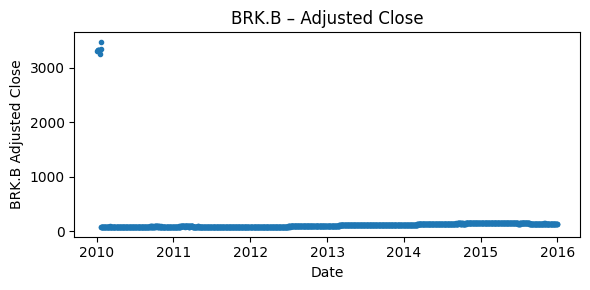

In [10]:
# look at the outlier
plot_symbol(df, "BRK.B", "Adjusted Close")

In [11]:
# drop the outlier
outlier_count = int(outliers.sum())
if outlier_count:
    flagged_symbols = outlier_symbols.unique()
    symbol_mask = df['Symbol'].isin(flagged_symbols)
    removed_rows = int(symbol_mask.sum())
    df = df.loc[~symbol_mask].copy()
    print(
        f"\nDropped {removed_rows} rows by removing symbols {flagged_symbols} "
        "that breached the ±6σ threshold. Remaining rows: "
        f"{len(df)}."
    )
else:
    print("\nNo outlier rows detected; dataset unchanged.")


Dropped 1510 rows by removing symbols ['BRK.B'] that breached the ±6σ threshold. Remaining rows: 269615.


In [12]:
# Trading session index will be useful for later (zero based)
unique_dates = pd.Index(sorted(df['Date'].unique()))
date_to_idx = pd.Series(np.arange(len(unique_dates), dtype=int), index=unique_dates)
df['TradingDayIdx'] = df['Date'].map(date_to_idx)

## Label the data

In [13]:
# labeling done in a utility function (adjustable window and market proxy)
df = forward_beta(df, market = 'SPY', window = 45)

# sanity checks
spy = df[df["Symbol"].eq("SPY")]
b = spy["beta45_fwd"].dropna()
a = spy["alpha45_fwd"].dropna()
print(f"SPY β: n={b.size}, mean={b.mean():.6f}, std={b.std():.2e}, min/max={b.min():.3f}/{b.max():.3f}")
print(f"SPY α (bps): mean={a.mean()*1e4:.2f}, std={a.std()*1e4:.2f}, min/max={a.min()*1e4:.2f}/{a.max()*1e4:.2f}, max|α|={a.abs().max()*1e4:.2f}")
print(f"MktVar45_fwd > 0 ratio: {(df['MktVar45_fwd'] > 0).mean():.3f}")

# Cross-sectional completeness at a sample interior date
sample_date = df["Date"].dropna().iloc[1000]
d_all = df.loc[df["Date"].eq(sample_date), "Symbol"].nunique()
d = df.loc[df["Date"].eq(sample_date), ["Symbol", "beta_true", "Ret_Mkt"]].dropna()
print(f"Cross-sec @ {sample_date:%Y-%m-%d}: {len(d)}/{d_all} names with complete β & market return ({len(d)/d_all:.0%} coverage)")

SPY β: n=1464, mean=1.000000, std=2.15e-15, min/max=1.000/1.000
SPY α (bps): mean=-0.00, std=0.00, min/max=-0.00/0.00, max|α|=0.00
MktVar45_fwd > 0 ratio: 0.968
Cross-sec @ 2011-11-28: 174/174 names with complete β & market return (100% coverage)


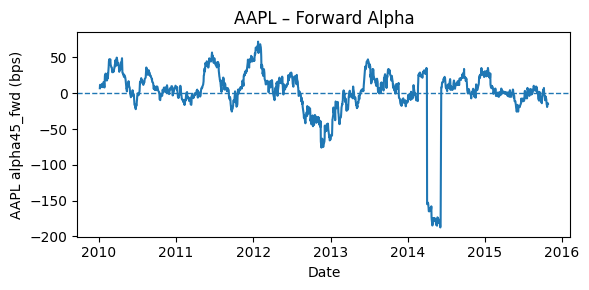

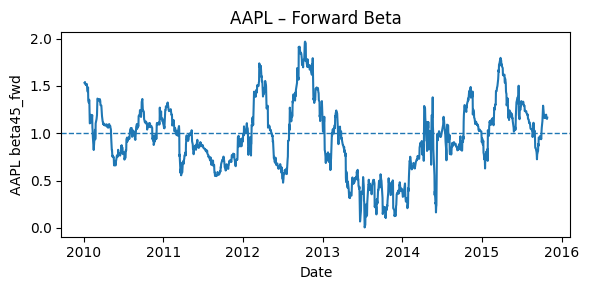

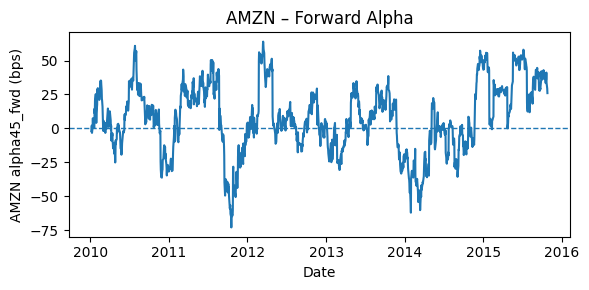

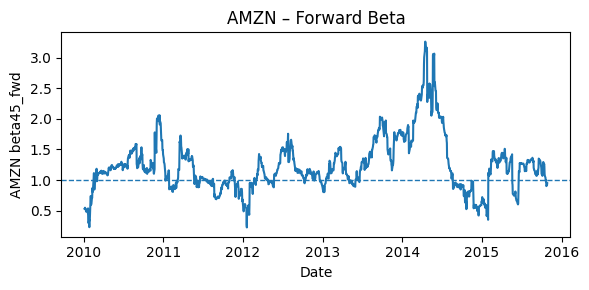

In [14]:
plot_symbol(df, "AAPL", "alpha45_fwd", alpha_in_bps=True)
plot_symbol(df, "AAPL", "beta45_fwd")
plot_symbol(df, "AMZN", "alpha45_fwd", alpha_in_bps=True)
plot_symbol(df, "AMZN", "beta45_fwd")

## Split the data into train, embargo, and test

In [15]:
# Chronological split + 45-day embargo
# Train = first 70% by time
# Test after embargo
W = 45
cut = int(df["TradingDayIdx"].max() * 0.70)
train_mask = df["TradingDayIdx"] <= cut
test_mask  = df["TradingDayIdx"] >= (cut + W)  # embargo

## Phase 1 — Pure Carry (baseline)

**Idea:** The simplest first guess for the future is the past.

**Model:**
$$
\hat{\beta}_T = \beta^{\text{back}}_{45,T}~
$$
- **Inputs:** trailing 45‑day beta at $T$.  
- **Parameters:** none
- **Fit:** none

Model,MSE,MAE,corr
Phase 1: Pure Carry,0.2164,0.2869,0.899


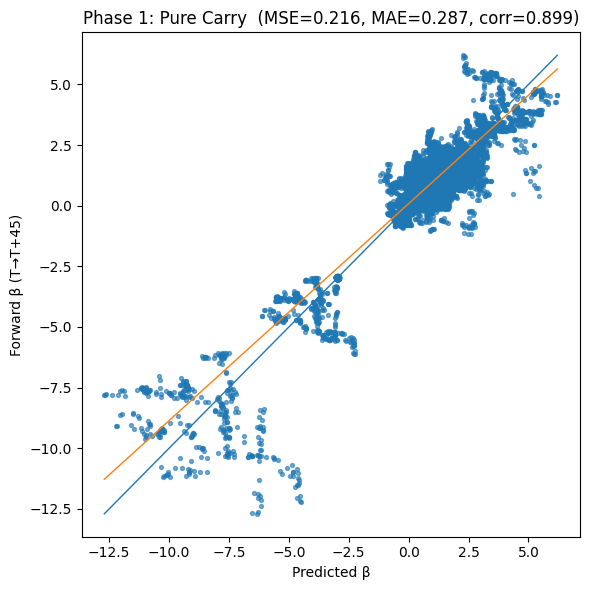

In [16]:
# Trailing beta (no shift)
grp = df.groupby("Symbol")

# trailing covariance Ret vs Ret_Mkt
cov45_back = (grp[["Ret","Ret_Mkt"]]
                .rolling(W, min_periods=W).cov(ddof=1)
                .xs("Ret", level=-1)["Ret_Mkt"]
                .reset_index(level=0, drop=True))
df["Cov45_back"] = cov45_back

# trailing market variance (use SPY series to avoid duplication)
spy_ret = (df.loc[df["Symbol"].eq("SPY"), ["Date","Ret"]]
             .dropna().set_index("Date")["Ret"])
mktvar45_back = spy_ret.rolling(W, min_periods=W).var(ddof=1).rename("MktVar45_back")
df["MktVar45_back"] = df["Date"].map(mktvar45_back)

# backward looking beta
df["beta45_back"] = df["Cov45_back"] / df["MktVar45_back"]

# prediction
df["predicted_beta_45d_baseline"] = df["beta45_back"]

# Only evaluate when both label and prediction exist
ok = df["beta45_fwd"].notna() & df["predicted_beta_45d_baseline"].notna()
y_true = df.loc[test_mask & ok, "beta45_fwd"]
y_pred = df.loc[test_mask & ok, "predicted_beta_45d_baseline"]

# results
report_result(df, "Phase 1: Pure Carry", "predicted_beta_45d_baseline", test_mask, "beta45_fwd")

## extra performance analysis

Wrote baseline_predictions.csv


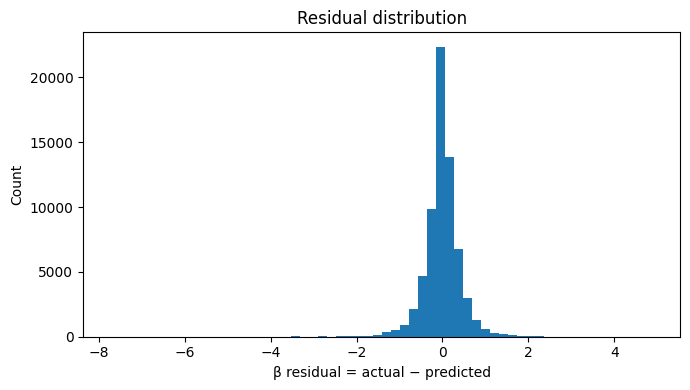

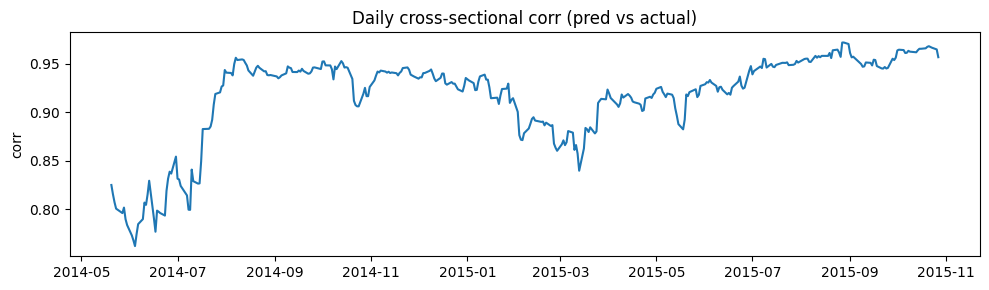

In [17]:
# quick csv file
pred_out = df.loc[test_mask & ok, ["Symbol","Date","predicted_beta_45d_baseline"]].copy()
pred_out.to_csv("baseline_predictions.csv", index=False)
print("Wrote baseline_predictions.csv")

# How tiny do forward market variances get?
df["MktVar45_fwd"].quantile([0, 0.001, 0.01, 0.05, 0.5, 0.95, 0.99, 0.999])

# Inspect the 10 biggest |beta45_fwd| to see what's going on
df.loc[df["beta45_fwd"].abs().nlargest(10).index, ["Symbol","Date","beta45_fwd","MktVar45_fwd","Cov45_fwd"]]

# read from csv file we just made
pred = pd.read_csv("baseline_predictions.csv", parse_dates=["Date"])
eval_df = (pred.merge(df[["Symbol","Date","beta45_fwd","beta45_back"]], on=["Symbol","Date"], how="left")
                 .dropna(subset=["beta45_fwd"]))
eval_df["resid"] = eval_df["beta45_fwd"] - eval_df["predicted_beta_45d_baseline"]

# residuals
plt.figure(figsize=(7,4))
plt.hist(eval_df["resid"], bins=60)
plt.xlabel("β residual = actual − predicted"); plt.ylabel("Count")
plt.title("Residual distribution")
plt.tight_layout(); plt.show()

# daily cross-sectional correlation (predicted vs. actual)
daily_corr = (eval_df.groupby("Date")
                     .apply(lambda g: g["predicted_beta_45d_baseline"].corr(g["beta45_fwd"]), include_groups=False)
                     .dropna())
plt.figure(figsize=(10,3))
plt.plot(daily_corr.index, daily_corr.values)
plt.ylabel("corr"); plt.title("Daily cross-sectional corr (pred vs actual)")
plt.tight_layout(); plt.show()

## Phase 2: Carry with shrinkage

**Idea:** Beta is persistent but noisy in short windows. Use the current trailing beta, then shrink it toward 1 (the market) to reduce noise.

**Model:**
$$
\hat{\beta}_T = (1-\lambda) \beta^{\text{back}}_{45,T} + \lambda~,
$$
a convex combination of the trailing 45‑day beta and the market beta.

- **Inputs:** trailing 45‑day beta at $T$.  
- **Parameter:** $\lambda \in [0,1]$ .  
- **Fit:** choose $\lambda$ on the train block (e.g., minimize MSE).

Model,MSE,MAE,corr
Phase 1: Pure Carry,0.2164,0.2869,0.899
Phase 2: Carry with shrinkage (λ=0.49),0.3687,0.3044,0.899


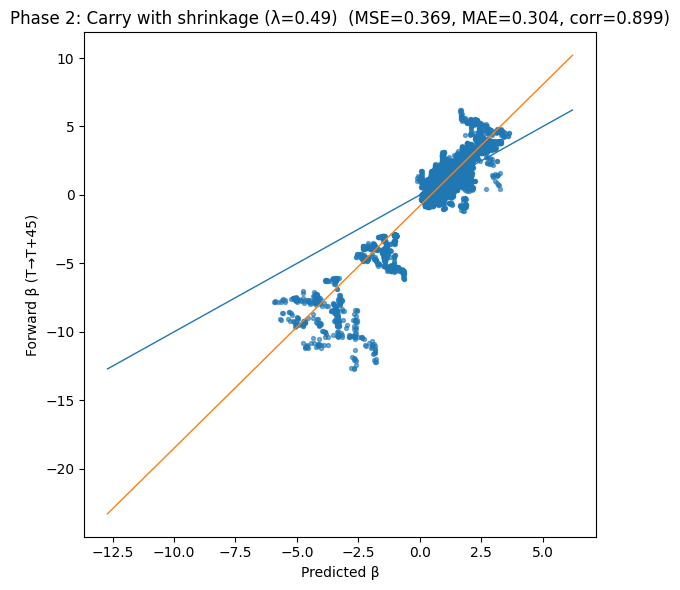

In [18]:
# choose lambda on the train (minimise MSE in closed form)
ok_train = train_mask & df["beta45_fwd"].notna() & df["beta45_back"].notna()
b = df.loc[ok_train, "beta45_back"].to_numpy()
y = df.loc[ok_train, "beta45_fwd"].to_numpy()
lam = float(np.clip(((b - y) * (b - 1.0)).mean() / ((b - 1.0) ** 2).mean(), 0.0, 1.0))

# predict 
df["pred_beta45_shrink"] = 1.0 + (1.0 - lam) * (df["beta45_back"] - 1.0)

# results
report_result(df, f"Phase 2: Carry with shrinkage (λ={lam:.2f})", "pred_beta45_shrink", test_mask, "beta45_fwd")

## Phase 3 — Multi-lookback carry

**Idea:** Short windows react fast but are noisy; long windows are stable but lag. Let them **vote** to reduce first-order lag.

**Model:**
$$
\hat{\beta}_T = b_0 + w_{20}\,\beta^{\text{back}}_{20,T}
             + w_{45}\,\beta^{\text{back}}_{45,T}
             + w_{90}\,\beta^{\text{back}}_{90,T}
$$
- **Inputs:** trailing betas at 20/45/90 days (all at $T$).
- **Parameters:** $b_0$, $w_{20}$, $w_{45}$, $w_{90}$
- **Fit:** ordinary least squares (OLS) on the training block (time-ordered 70/30 with a 45-day embargo), minimizing the **sum of squared errors** vs. $\beta^{\text{fwd}}_{45,T}$.

Model,MSE,MAE,corr
Phase 1: Pure Carry,0.2164,0.2869,0.899
Phase 3: Multi-lookback OLS,0.2536,0.2717,0.873
Phase 2: Carry with shrinkage (λ=0.49),0.3687,0.3044,0.899


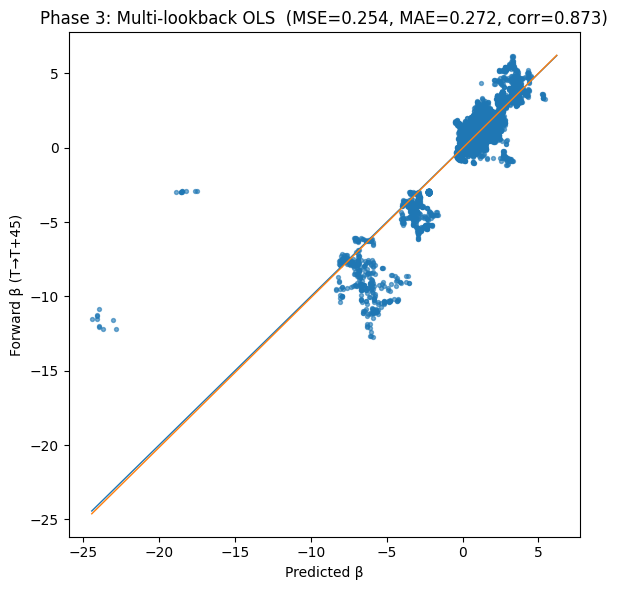

In [19]:
# build trailing betas for W in {20,45,90} (ddof=1, no shift)
for W in (20, 45, 90):
    spy = (df.loc[df["Symbol"].eq("SPY"), ["Date","Ret"]]
             .dropna(subset=["Ret"])
             .set_index("Date")["Ret"])
    df[f"MktVar{W}_back"] = df["Date"].map(spy.rolling(W, min_periods=W).var(ddof=1))

    grp = df.groupby("Symbol")
    cov_mat = grp[["Ret","Ret_Mkt"]].rolling(W, min_periods=W).cov(ddof=1)
    cov_back = cov_mat.xs("Ret", level=-1)["Ret_Mkt"].reset_index(level=0, drop=True)
    df[f"Cov{W}_back"] = cov_back

    df[f"beta{W}_back"] = df[f"Cov{W}_back"] / df[f"MktVar{W}_back"]

# design matrix: betas at {20,45,90}, target: beta45_fwd
need = ["beta20_back","beta45_back","beta90_back","beta45_fwd"]
ok = df[need].notna().all(axis=1)
X = df.loc[ok, ["beta20_back","beta45_back","beta90_back"]].values
y = df.loc[ok, "beta45_fwd"].values
idx_ok = df.index[ok]
X_train = X[train_mask[ok].values]
y_train = y[train_mask[ok].values]
X_train_ = np.c_[np.ones(len(X_train)), X_train]

# fit
w = np.linalg.lstsq(X_train_, y_train, rcond=None)[0]   # [b0, w20, w45, w90]

# predict
X_test = X[test_mask[ok].values]
X_test_ = np.c_[np.ones(len(X_test)), X_test]
y_true = y[test_mask[ok].values]
y_pred = X_test_ @ w
test_idx = idx_ok[test_mask[ok].values]
df.loc[test_idx, "pred_beta45_phase3"] = y_pred

# results
report_result(df, "Phase 3: Multi-lookback OLS", "pred_beta45_phase3", test_mask, "beta45_fwd")

## Phase 4 — Dynamic beta (EWMA smoother)

**Idea:** Treat beta as a slowly drifting state. Give more weight to recent days and less to older days.

**Model:**
$$
\beta^{\mathrm{ewm}}_{H,T}
= \frac{\operatorname{Cov}^{\mathrm{ewm}}_{H}(r_i, r_m)_T}{\operatorname{Var}^{\mathrm{ewm}}_{H}(r_m)_T}
$$
Here the covariance and variance are exponentially weighted up to day $T$ with half-life $H$ (recent days get more weight; weights halve every $H$ days).

- **Inputs:** returns up to $T$; half-life grid (e.g., $H\in\{10,20,45,90\}$).  
- **Parameter:** half-life $H$.  
- **Fit:** try grid of $H$ values on train and choose $H^*$ with lowest MSE vs the forward label.


Model,MSE,MAE,corr
Phase 1: Pure Carry,0.2164,0.2869,0.899
Phase 4: EWMA (H=80),0.2331,0.2568,0.907
Phase 3: Multi-lookback OLS,0.2536,0.2717,0.873
Phase 2: Carry with shrinkage (λ=0.49),0.3687,0.3044,0.899


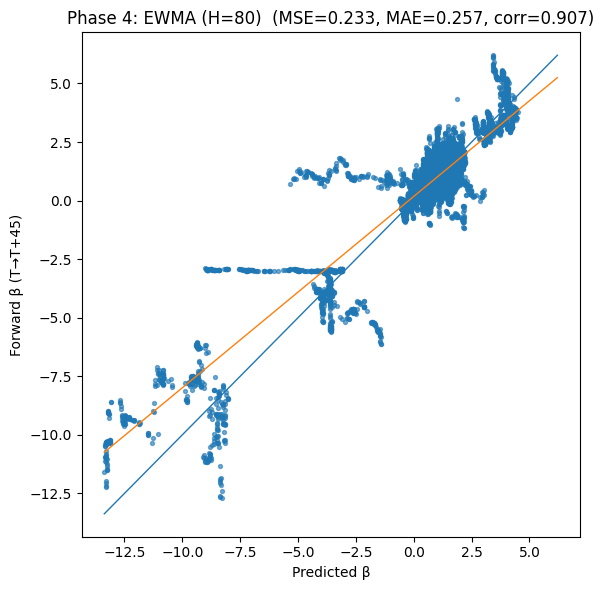

In [20]:
# EWMA beta helper (per symbol)
def _ewm_beta(g, H):
    r = g["Ret"]; m = g["Ret_Mkt"]
    mu_r = r.ewm(halflife=H, min_periods=H, adjust=False).mean()
    mu_m = m.ewm(halflife=H, min_periods=H, adjust=False).mean()
    e_rm = (r * m).ewm(halflife=H, min_periods=H, adjust=False).mean()
    e_m2 = (m * m).ewm(halflife=H, min_periods=H, adjust=False).mean()
    cov  = e_rm - mu_r * mu_m
    varm = e_m2 - mu_m.pow(2)
    return cov / varm

# compute EWMA betas (no MultiIndex, aligns with df.index)
Hs = [60, 70, 80, 90, 100, 110]
for H in Hs:
    s = df.groupby("Symbol", group_keys=False).apply(lambda g: _ewm_beta(g, H), include_groups=False)
    df[f"beta_ewm{H}"] = s

# split (same as phase 1)
W = 45
cut = int(df["TradingDayIdx"].max() * 0.70)
train_mask = df["TradingDayIdx"] <= cut
test_mask  = df["TradingDayIdx"] >= (cut + W)

# pick H on the train block (min MSE vs beta45_fwd)
best = None
for H in Hs:
    ok = df["beta45_fwd"].notna() & df[f"beta_ewm{H}"].notna() & train_mask
    if ok.any():
        y    = df.loc[ok, "beta45_fwd"]
        yhat = df.loc[ok, f"beta_ewm{H}"]
        mse  = float(((yhat - y) ** 2).mean())
        if best is None or mse < best[0]:
            best = (mse, H)

H_star = best[1]
df["pred_beta45_phase4"] = df[f"beta_ewm{H_star}"]

# metrics on the test block
ok_test = df["beta45_fwd"].notna() & df["pred_beta45_phase4"].notna() & test_mask
y_true = df.loc[ok_test, "beta45_fwd"]
y_pred = df.loc[ok_test, "pred_beta45_phase4"]

# results
report_result(df, f"Phase 4: EWMA (H={H_star})", "pred_beta45_phase4", test_mask, "beta45_fwd")